<a href="https://colab.research.google.com/github/ugurdonmez/bitcoin_price_predict/blob/main/bnb_day.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD

In [3]:
%cd /content/drive/MyDrive/Colab\ Notebooks/bnb

/content/drive/MyDrive/Colab Notebooks/bnb


In [6]:
data = pd.read_csv('BNB-USD.csv')

In [8]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-07-25,0.115203,0.115841,0.101531,0.105870,0.105870,1.452690e+05
1,2017-07-26,0.105893,0.109013,0.099266,0.105138,0.105138,2.003950e+05
2,2017-07-27,0.105108,0.108479,0.100888,0.107737,0.107737,3.444990e+05
3,2017-07-28,0.107632,0.109019,0.101473,0.104067,0.104067,3.425680e+05
4,2017-07-29,0.104782,0.111264,0.101108,0.107811,0.107811,3.402180e+05
...,...,...,...,...,...,...,...
1443,2021-07-07,320.191772,339.167664,318.529968,327.522461,327.522461,2.067233e+09
1444,2021-07-08,327.957855,327.957855,305.075439,310.427124,310.427124,1.883785e+09
1445,2021-07-09,310.010284,319.443909,301.828217,316.484528,316.484528,1.358584e+09
1446,2021-07-10,316.996307,320.939270,310.886902,316.140137,316.140137,1.179686e+09


In [9]:
data['short_mavg'] = data['Close'].rolling(window=10, min_periods=1, center=False).mean()

In [10]:
data['long_mavg'] = data['Close'].rolling(window=60, min_periods=1, center=False).mean()

In [11]:
data['signal'] = np.where(data['short_mavg'] > data['long_mavg'], 1.0, 0.0)

In [12]:
data

,Date,Open,High,Low,Close,Adj Close,Volume,short_mavg,long_mavg,signal
0,2017-07-25,0.115203,0.115841,0.101531,0.105870,0.105870,1.452690e+05,0.105870,0.105870,0.0
1,2017-07-26,0.105893,0.109013,0.099266,0.105138,0.105138,2.003950e+05,0.105504,0.105504,0.0
2,2017-07-27,0.105108,0.108479,0.100888,0.107737,0.107737,3.444990e+05,0.106248,0.106248,0.0
3,2017-07-28,0.107632,0.109019,0.101473,0.104067,0.104067,3.425680e+05,0.105703,0.105703,0.0
4,2017-07-29,0.104782,0.111264,0.101108,0.107811,0.107811,3.402180e+05,0.106125,0.106125,0.0
...,...,...,...,...,...,...,...,...,...,...
1443,2021-07-07,320.191772,339.167664,318.529968,327.522461,327.522461,2.067233e+09,302.548752,376.307893,0.0
1444,2021-07-08,327.957855,327.957855,305.075439,310.427124,310.427124,1.883785e+09,304.638052,370.444535,0.0
1445,2021-07-09,310.010284,319.443909,301.828217,316.484528,316.484528,1.358584e+09,306.265350,365.196744,0.0
1446,2021-07-10,316.996307,320.939270,310.886902,316.140137,316.140137,1.179686e+09,307.549777,359.260181,0.0


In [13]:
data.shape

(1448, 10)

In [16]:
def EMA(df, n):
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA

In [17]:
data['EMA10'] = EMA(data, 10)
data['EMA30'] = EMA(data, 30)
data['EMA200'] = EMA(data, 200)
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,short_mavg,long_mavg,signal,EMA10,EMA30,EMA200
1443,2021-07-07,320.191772,339.167664,318.529968,327.522461,327.522461,2.067233e+09,302.548752,376.307893,0.0,307.606455,324.495447,300.076822
1444,2021-07-08,327.957855,327.957855,305.075439,310.427124,310.427124,1.883785e+09,304.638052,370.444535,0.0,308.119304,323.587813,300.180029
1445,2021-07-09,310.010284,319.443909,301.828217,316.484528,316.484528,1.358584e+09,306.265350,365.196744,0.0,309.640253,323.129537,300.342605
1446,2021-07-10,316.996307,320.939270,310.886902,316.140137,316.140137,1.179686e+09,307.549777,359.260181,0.0,310.822050,322.678608,300.500123
1447,2021-07-11,316.467865,319.798035,312.674164,319.247559,319.247559,1.074363e+09,310.652692,354.777887,0.0,312.353961,322.457250,300.687051


In [18]:
def ROC(df, n):  
    M = df.diff(n - 1)  
    N = df.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC

In [19]:
data['ROC10'] = ROC(data['Close'], 10)
data['ROC30'] = ROC(data['Close'], 30)

In [20]:
data.tail(10)

,Date,Open,High,Low,Close,Adj Close,Volume,short_mavg,long_mavg,signal,EMA10,EMA30,EMA200,ROC10,ROC30
1438,2021-07-02,287.754456,290.621674,277.350311,287.423096,287.423096,1.133633e+09,292.319635,403.141278,0.0,296.106116,329.312545,299.489574,-2.399807,-32.814920
1439,2021-07-03,287.215607,302.605865,283.434021,298.237122,298.237122,1.113777e+09,292.694318,397.925224,0.0,296.493572,327.307679,299.477084,-3.294426,-23.801563
1440,2021-07-04,298.113556,314.713013,292.787384,307.732086,307.732086,1.387396e+09,292.627823,392.193047,0.0,298.536938,326.044738,299.559406,9.271746,-21.181614
1441,2021-07-05,307.684845,307.684845,293.523468,302.377991,302.377991,1.504870e+09,294.703531,386.678007,0.0,299.235311,324.517851,299.587513,8.209312,-23.219283
1442,2021-07-06,302.195587,321.520966,302.195587,320.934814,320.934814,2.203265e+09,298.853207,381.617532,0.0,303.180675,324.286687,299.800386,10.451220,-10.180341
1443,2021-07-07,320.191772,339.167664,318.529968,327.522461,327.522461,2.067233e+09,302.548752,376.307893,0.0,307.606455,324.495447,300.076822,13.120506,-7.479890
1444,2021-07-08,327.957855,327.957855,305.075439,310.427124,310.427124,1.883785e+09,304.638052,370.444535,0.0,308.119304,323.587813,300.180029,3.402792,-17.381296
1445,2021-07-09,310.010284,319.443909,301.828217,316.484528,316.484528,1.358584e+09,306.265350,365.196744,0.0,309.640253,323.129537,300.342605,4.348447,-10.136392
1446,2021-07-10,316.996307,320.939270,310.886902,316.140137,316.140137,1.179686e+09,307.549777,359.260181,0.0,310.822050,322.678608,300.500123,9.687696,-8.612503
1447,2021-07-11,316.467865,319.798035,312.674164,319.247559,319.247559,1.074363e+09,310.652692,354.777887,0.0,312.353961,322.457250,300.687051,11.072340,-7.125559


In [21]:
def MOM(df, n):   
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))   
    return MOM


In [22]:
data['MOM10'] = MOM(data['Close'], 10)
data['MOM30'] = MOM(data['Close'], 30)

In [23]:
data.tail(10)

,Date,Open,High,Low,Close,Adj Close,Volume,short_mavg,long_mavg,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30
1438,2021-07-02,287.754456,290.621674,277.350311,287.423096,287.423096,1.133633e+09,292.319635,403.141278,0.0,296.106116,329.312545,299.489574,-2.399807,-32.814920,25.605011,-113.839233
1439,2021-07-03,287.215607,302.605865,283.434021,298.237122,298.237122,1.113777e+09,292.694318,397.925224,0.0,296.493572,327.307679,299.477084,-3.294426,-23.801563,3.746827,-129.570800
1440,2021-07-04,298.113556,314.713013,292.787384,307.732086,307.732086,1.387396e+09,292.627823,392.193047,0.0,298.536938,326.044738,299.559406,9.271746,-21.181614,-0.664948,-83.663239
1441,2021-07-05,307.684845,307.684845,293.523468,302.377991,302.377991,1.504870e+09,294.703531,386.678007,0.0,299.235311,324.517851,299.587513,8.209312,-23.219283,20.757080,-88.053863
1442,2021-07-06,302.195587,321.520966,302.195587,320.934814,320.934814,2.203265e+09,298.853207,381.617532,0.0,303.180675,324.286687,299.800386,10.451220,-10.180341,41.496765,-72.885407
1443,2021-07-07,320.191772,339.167664,318.529968,327.522461,327.522461,2.067233e+09,302.548752,376.307893,0.0,307.606455,324.495447,300.076822,13.120506,-7.479890,36.955444,-29.787750
1444,2021-07-08,327.957855,327.957855,305.075439,310.427124,310.427124,1.883785e+09,304.638052,370.444535,0.0,308.119304,323.587813,300.180029,3.402792,-17.381296,20.893005,-43.574249
1445,2021-07-09,310.010284,319.443909,301.828217,316.484528,316.484528,1.358584e+09,306.265350,365.196744,0.0,309.640253,323.129537,300.342605,4.348447,-10.136392,16.272980,-59.250152
1446,2021-07-10,316.996307,320.939270,310.886902,316.140137,316.140137,1.179686e+09,307.549777,359.260181,0.0,310.822050,322.678608,300.500123,9.687696,-8.612503,12.844269,-36.043060
1447,2021-07-11,316.467865,319.798035,312.674164,319.247559,319.247559,1.074363e+09,310.652692,354.777887,0.0,312.353961,322.457250,300.687051,11.072340,-7.125559,31.029145,-26.686126


In [24]:
def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 rs = u.ewm(com=period-1, adjust=False).mean() / \
 d.ewm(com=period-1, adjust=False).mean()
 return 100 - 100 / (1 + rs)

In [25]:
data['RSI10'] = RSI(data['Close'], 10)
data['RSI30'] = RSI(data['Close'], 30)
data['RSI200'] = RSI(data['Close'], 200)

In [26]:
def STOK(close, low, high, n): 
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 return STOK

In [27]:
def STOD(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 STOD = STOK.rolling(3).mean()
 return STOD

In [28]:
data['%K10'] = STOK(data['Close'], data['Low'], data['High'], 10)
data['%D10'] = STOD(data['Close'], data['Low'], data['High'], 10)
data['%K30'] = STOK(data['Close'], data['Low'], data['High'], 30)
data['%D30'] = STOD(data['Close'], data['Low'], data['High'], 30)
data['%K200'] = STOK(data['Close'], data['Low'], data['High'], 200)
data['%D200'] = STOD(data['Close'], data['Low'], data['High'], 200)

In [30]:
data.tail(10)

,Date,Open,High,Low,Close,Adj Close,Volume,short_mavg,long_mavg,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,RSI10,RSI30,RSI200,%K10,%D10,%K30,%D30,%K200,%D200
1438,2021-07-02,287.754456,290.621674,277.350311,287.423096,287.423096,1.133633e+09,292.319635,403.141278,0.0,296.106116,329.312545,299.489574,-2.399807,-32.814920,25.605011,-113.839233,40.394625,43.573327,51.582300,55.041824,63.529502,29.670977,32.367945,39.034770,39.915118
1439,2021-07-03,287.215607,302.605865,283.434021,298.237122,298.237122,1.113777e+09,292.694318,397.925224,0.0,296.493572,327.307679,299.477084,-3.294426,-23.801563,3.746827,-129.570800,45.424017,44.589606,51.788655,65.199207,63.041207,35.587908,31.771973,40.668637,39.630813
1440,2021-07-04,298.113556,314.713013,292.787384,307.732086,307.732086,1.387396e+09,292.627823,392.193047,0.0,298.536938,326.044738,299.559406,9.271746,-21.181614,-0.664948,-83.663239,49.574898,45.481477,51.969294,84.839693,68.360241,40.797720,35.352202,42.047573,40.583660
1441,2021-07-05,307.684845,307.684845,293.523468,302.377991,302.377991,1.504870e+09,294.703531,386.678007,0.0,299.235311,324.517851,299.587513,8.209312,-23.219283,20.757080,-88.053863,47.319967,45.058416,51.859176,74.308080,74.782327,42.015167,39.466932,41.237858,41.318023
1442,2021-07-06,302.195587,321.520966,302.195587,320.934814,320.934814,2.203265e+09,298.853207,381.617532,0.0,303.180675,324.286687,299.800386,10.451220,-10.180341,41.496765,-72.885407,55.172213,46.831634,52.211892,98.855866,86.001213,52.263149,45.025345,44.012583,42.432671
1443,2021-07-07,320.191772,339.167664,318.529968,327.522461,327.522461,2.067233e+09,302.548752,376.307893,0.0,307.606455,324.495447,300.076822,13.120506,-7.479890,36.955444,-29.787750,57.661459,47.454432,52.336487,81.161919,84.775288,66.003714,53.427343,45.009415,43.419952
1444,2021-07-08,327.957855,327.957855,305.075439,310.427124,310.427124,1.883785e+09,304.638052,370.444535,0.0,308.119304,323.587813,300.180029,3.402792,-17.381296,20.893005,-43.574249,49.703331,46.007678,51.983005,53.507327,77.841704,54.856666,57.707843,42.422574,43.814857
1445,2021-07-09,310.010284,319.443909,301.828217,316.484528,316.484528,1.358584e+09,306.265350,365.196744,0.0,309.640253,323.129537,300.342605,4.348447,-10.136392,16.272980,-59.250152,52.295430,46.604378,52.098218,63.306200,65.991815,58.806408,59.888929,43.339172,43.590387
1446,2021-07-10,316.996307,320.939270,310.886902,316.140137,316.140137,1.179686e+09,307.549777,359.260181,0.0,310.822050,322.678608,300.500123,9.687696,-8.612503,12.844269,-36.043060,52.125728,46.574105,52.091076,62.749089,59.854205,58.581847,57.414974,43.287059,43.016268
1447,2021-07-11,316.467865,319.798035,312.674164,319.247559,319.247559,1.074363e+09,310.652692,354.777887,0.0,312.353961,322.457250,300.687051,11.072340,-7.125559,31.029145,-26.686126,53.634166,46.896084,52.150558,67.775869,64.610386,60.608048,59.332101,43.724782,43.450338


In [31]:
def MA(df, n):
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA

In [32]:
data['MA21'] = MA(data, 10)
data['MA63'] = MA(data, 30)
data['MA252'] = MA(data, 200)
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,short_mavg,long_mavg,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,RSI10,RSI30,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
1443,2021-07-07,320.191772,339.167664,318.529968,327.522461,327.522461,2.067233e+09,302.548752,376.307893,0.0,307.606455,324.495447,300.076822,13.120506,-7.479890,36.955444,-29.787750,57.661459,47.454432,52.336487,81.161919,84.775288,66.003714,53.427343,45.009415,43.419952,302.548752,320.192229,282.727982
1444,2021-07-08,327.957855,327.957855,305.075439,310.427124,310.427124,1.883785e+09,304.638052,370.444535,0.0,308.119304,323.587813,300.180029,3.402792,-17.381296,20.893005,-43.574249,49.703331,46.007678,51.983005,53.507327,77.841704,54.856666,57.707843,42.422574,43.814857,304.638052,318.739754,284.109316
1445,2021-07-09,310.010284,319.443909,301.828217,316.484528,316.484528,1.358584e+09,306.265350,365.196744,0.0,309.640253,323.129537,300.342605,4.348447,-10.136392,16.272980,-59.250152,52.295430,46.604378,52.098218,63.306200,65.991815,58.806408,59.888929,43.339172,43.590387,306.265350,316.764749,285.530391
1446,2021-07-10,316.996307,320.939270,310.886902,316.140137,316.140137,1.179686e+09,307.549777,359.260181,0.0,310.822050,322.678608,300.500123,9.687696,-8.612503,12.844269,-36.043060,52.125728,46.574105,52.091076,62.749089,59.854205,58.581847,57.414974,43.287059,43.016268,307.549777,315.563314,286.943677
1447,2021-07-11,316.467865,319.798035,312.674164,319.247559,319.247559,1.074363e+09,310.652692,354.777887,0.0,312.353961,322.457250,300.687051,11.072340,-7.125559,31.029145,-26.686126,53.634166,46.896084,52.150558,67.775869,64.610386,60.608048,59.332101,43.724782,43.450338,310.652692,314.673776,288.384426


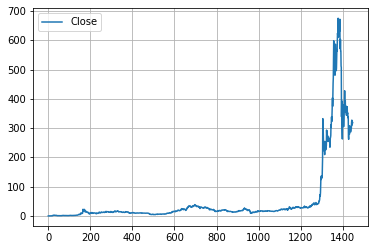

In [33]:
data[['Close']].plot(grid=True)
plt.show()

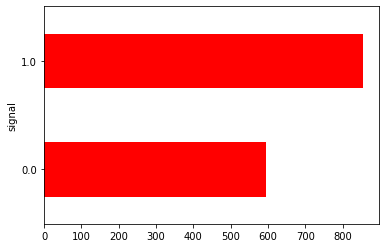

In [34]:
fig = plt.figure()
plot = data.groupby(['signal']).size().plot(kind='barh', color = 'red')
plt.show()

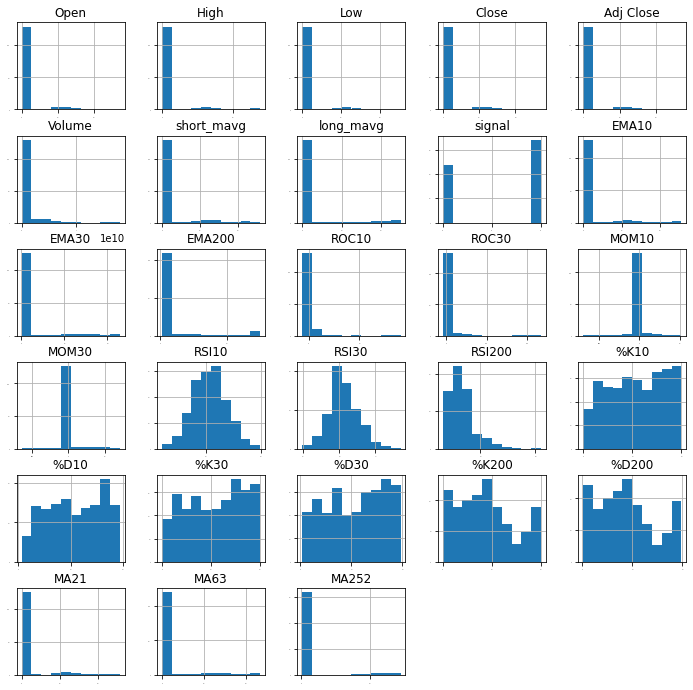

In [35]:
data.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

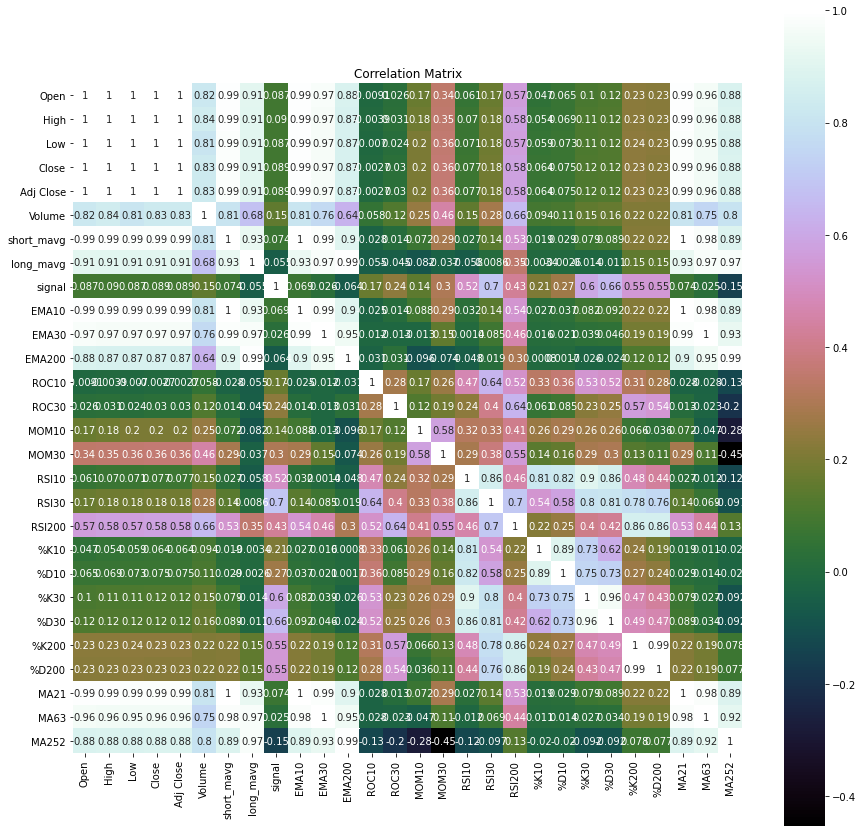

In [36]:
correlation = data.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

In [37]:
data = data.drop(columns=['Date'])

In [43]:
data = data.dropna()

In [44]:
subset_dataset= data.iloc[-10000:]
Y= subset_dataset["signal"]
X = subset_dataset.loc[:, data.columns != 'signal']
validation_size = 0.2
seed = 1
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=1)

In [45]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensable Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

In [46]:
num_folds = 10
seed = 7
scoring = 'accuracy'

In [47]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


LR: 0.555052 (0.044514)
LDA: 0.930683 (0.032775)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


KNN: 0.627308 (0.043362)
CART: 0.940745 (0.028574)
NB: 0.536211 (0.041044)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reache

NN: 0.497122 (0.068014)
AB: 0.975404 (0.013076)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


GBM: 0.973975 (0.012645)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


RF: 0.971097 (0.011227)


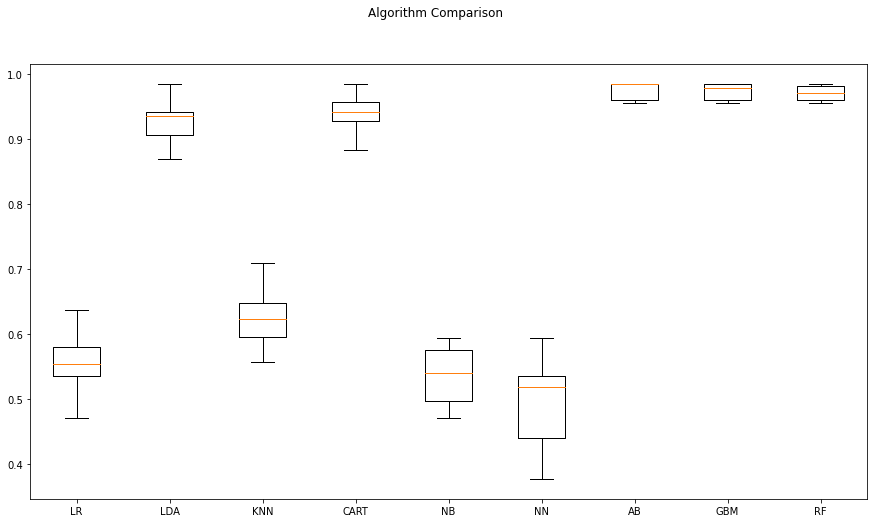

In [48]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

In [49]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [20,80]
max_depth= [5,10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Best: 0.971139 using {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#8 0.952340 (0.020439) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#6 0.961035 (0.020368) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#4 0.968261 (0.016733) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#2 0.971077 (0.017166) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#7 0.959565 (0.022139) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#5 0.963892 (0.016150) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#1 0.971139 (0.014329) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#3 0.969669 (0.015083) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}


In [50]:
model = RandomForestClassifier(criterion='gini', n_estimators=80,max_depth=10,n_jobs=-1) # rbf is default kernel
#model = LogisticRegression() 
model.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [51]:
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.9770114942528736
[[100   2]
 [  2  70]]
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       102
         1.0       0.97      0.97      0.97        72

    accuracy                           0.98       174
   macro avg       0.98      0.98      0.98       174
weighted avg       0.98      0.98      0.98       174



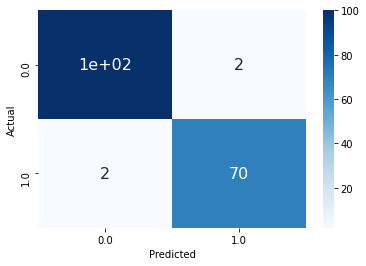

In [52]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font sizes

Text(0.5, 0, 'Variable Importance')

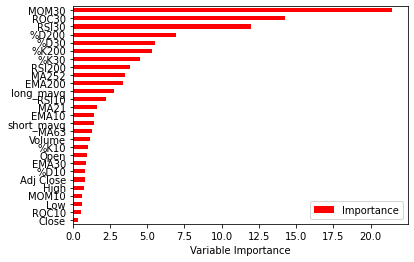

In [53]:
Importance = pd.DataFrame({'Importance':model.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r' )
plt.xlabel('Variable Importance')

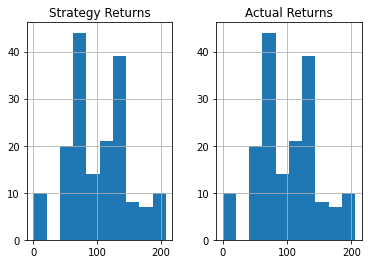

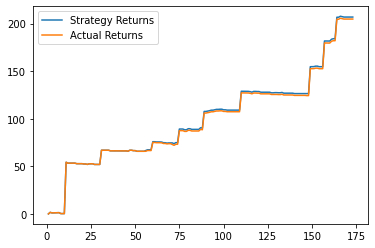

In [55]:
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
backtestdata = pd.DataFrame(index=X_validation.index)
#backtestdata = pd.DataFrame()
backtestdata['signal_pred'] = predictions
backtestdata['signal_actual'] = Y_validation
backtestdata['Market Returns'] = X_validation['Close'].pct_change()
backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)
backtestdata=backtestdata.reset_index()
backtestdata.head()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot()